In [12]:
import numpy as np
from sklearn.svm import LinearSVC
import time as tm
import random
from matplotlib import pyplot as plt

In [22]:
def checkoriginal(Z,c):
    y = Z[:,0]
    X = Z[:,1:]
    clf = LinearSVC(C=c,penalty = 'l2',loss = 'squared_hinge')
    clf.fit(X,y)
    w = clf.coef_
    finalans = ObjVal(np.append(w,clf.intercept_),c)
    return finalans


def randsplit(ratio,Z):
    np.random.shuffle(Z)
    y = Z[:,0]
    X = Z[:,1:]
    X_train = X[:int(ratio*(X.shape[0])),:]
    y_train = y[:int(ratio*(X.shape[0]))]
    X_validate = X[int(ratio*(X.shape[0])):,:]
    y_validate = y[int(ratio*(X.shape[0])):]
    return X_train,X_validate,y_train,y_validate

def CSVMgradient( theta ):
    w = theta[0:-1]
    b = theta[-1]
    discriminant = 1 - np.multiply( (X.dot( w ) + b), y )
    delb = C * np.maximum(discriminant,0).dot( y ) * (-2)
    delw = w + C * (X.T * np.maximum(discriminant,0)).dot( y ) * (-2)
    return np.append( delw, delb )

In [28]:
Z = np.loadtxt( "data" )

eta = 0.0006
#C = 1
(X,_,y,_) = randsplit(1,Z)
(n,) = y.shape
X = np.hstack((X, np.ones((n, 1))))
w = np.zeros(X.shape[1]+1)
d=20
randperm = np.random.permutation( y.size )
randpermInner = -1

def CDGradient(w,y,X,C,j):
    Discriminant = 1 - np.multiply( (X.dot( w )), y )
    return (w[j] - 2*C*(np.sum(np.maximum(Discriminant,0)*y*X[:,j])))
def ObjVal( theta, C ):
        w = theta[0:-1]
        b = theta[-1]
        Loss = hingelossSq(theta)
        return 0.5 * w.dot( w ) + C * Loss


In [29]:
def SCDMD2(X,y,C,d):
    (n,) = y.shape
#     C = 1
    def getStepLength( grad, t ):
        return eta/(t+2)

    def hingelossSq(theta):
        w = theta[0:-1]
        b = theta[-1]

    #     print("Nai")
        hingesq = np.square(np.maximum(1-np.multiply((X.dot(w) + b), y), 0))
        return np.sum(hingesq)

    def ObjVal( theta, C ):
        w = theta[0:-1]
        b = theta[-1]
        Loss = hingelossSq(theta)
        return 0.5 * w.dot( w ) + C * Loss


    ##Takes an element i and gives the value of derivative w.r.t it
    def SqGrad(theta,i):
        w = theta[0:-1]
        b = theta[-1]
        n = y.size
        x = X[i,:]
        discriminant = 1 - ((x.dot( w ) + b) * y[i])
        g = 0
    #     print(x*np.maximum(discriminant,0)*y[i])
        if discriminant < 1:
            g = -1
        delb = C * y[i] * (-2) * np.maximum(discriminant,0)
        delw = w + C *(x * n * np.maximum(discriminant,0)) * y[i] * (-2)
        return np.append( delw, delb )
    # print(discriminant)
    # SqGrad(-1*np.ones(21),2)

    def getCyclicCoord( currentCoord ):
        if currentCoord >= n-1 or currentCoord < 0:
            return 0
        else:
            return (currentCoord + 1)%n

    def getRandCoord( currentCoord ):
        return random.randint( 0, n -1 )

    def getRandpermCoord( currentCoord ):
        global randperm, randpermInner
        if currentCoord < 0 or randpermInner >= n-1 or randpermInner < 0 :
            randpermInner = 0
            randperm = np.random.permutation( y.size )
            return randperm[randpermInner]
        else:
            randpermInner = randpermInner + 1
            return randperm[randpermInner]

    def doSDCM( getCoordFunc, init, horizon = 10 ):
        primalObjValSeries = np.zeros( (int(horizon/200),) )
        #     dualObjValSeries = np.zeros( (horizon,) )
        timeSeries = np.zeros( (int(horizon/200),) )
        totTime = 0
        # Initialize model as well as some bookkeeping variables
        alpha = init
        alphay = np.multiply( alpha, y )
        # Initialize the model vector using the equations relating primal and dual variables
        w = X.T.dot( alphay )
        # Recall that we are imagining here that the data points have one extra dimension of ones
        # This extra dimension plays the role of the bias in this case
        b = alpha.dot( y )
        # Calculate squared norms taking care that we are appending an extra dimension of ones
        normSq = np.square( np.linalg.norm( X, axis = 1 ) ) + 1
        # We have not made any choice of coordinate yet
        i = -1
        tic = tm.perf_counter()
        for t in range( horizon ):
            i = getCoordFunc( i )
            x = X[i,:]
        #         print(x.shape)
            # Find the unconstrained new optimal value of alpha_i
            newAlphai =  (1 + alpha[i]*normSq[i] - y[i] * (x.dot(w) + b)) / (normSq[i] + 0.5*C)
            # Make sure that the constraints are satisfied
        #         if newAlphai > C:
        #             newAlphai = C
            if newAlphai < 0:
                newAlphai = 0

            # Update the model vector and bias values
            # Takes only O(d) time to do so :)
            w = w + (newAlphai - alpha[i]) * y[i] * x
            b = b + (newAlphai - alpha[i]) * y[i]

            alpha[i] = newAlphai


            if t%200 == 0:
#                 print(t)
                toc = tm.perf_counter()
                totTime = totTime + (toc - tic)
#                 primalObjValSeries[int(t/200)] = ObjVal( np.append( w, b ) )
                tic = tm.perf_counter()
                        #         dualObjValSeries[t] = ObjValDual( alpha, w, b )
                timeSeries[int(t/200)] = totTime

        print( "nSV = ", np.sum( alpha > C/100 ), " out of ", y.size, "data points" )
        return (np.append( w, b ), primalObjValSeries, timeSeries)

#     d=20
    (theta_SCD, obj_P1, time_SCD) = doSDCM( getRandpermCoord, np.zeros( (n,) ), horizon = 600000 )
#     plt.figure(figsize =(6,6))
#     plt.plot( time_SCD, obj_P1, color = 'r', linestyle = '-', label = "SCD" )
#     plt.xlabel( "Elapsed time (sec)" )
#     plt.ylabel( "P1 Objective value" )
#     plt.legend()
#     plt.show()
#     print(min(obj_P1))
    print("Time elapsed = {} sec".format(time_SCD[-1]))
    return ObjVal(theta_SCD,C)

Running for  0
nSV =  11351  out of  20000 data points
Time elapsed = 5.230085236900777 sec
Running for  1
nSV =  11406  out of  20000 data points
Time elapsed = 5.360667061140703 sec
Running for  2
nSV =  13330  out of  20000 data points
Time elapsed = 5.292437335108843 sec
Running for  3
nSV =  11367  out of  20000 data points
Time elapsed = 5.322381758156553 sec
Running for  4
nSV =  13575  out of  20000 data points
Time elapsed = 5.3248792509766645 sec
Running for  5
nSV =  13812  out of  20000 data points
Time elapsed = 5.40595739899436 sec
Running for  6
nSV =  12359  out of  20000 data points
Time elapsed = 5.251966551957594 sec
Running for  7
nSV =  11336  out of  20000 data points
Time elapsed = 5.216835563060158 sec
Running for  8
nSV =  12248  out of  20000 data points
Time elapsed = 5.296150887959811 sec
Running for  9
nSV =  13897  out of  20000 data points
Time elapsed = 5.212092265854153 sec
Running for  10
nSV =  11618  out of  20000 data points
Time elapsed = 5.3483209

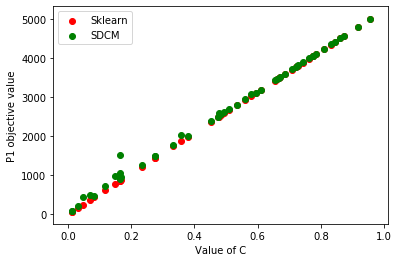

In [30]:
finaltruevalues = []

numc = np.random.random_sample((50,))
# numc = numc/2 + 1
finalval = []
for i in range(len(numc)):
    print('Running for ' ,i)
    finalval.append(SCDMD2(X,y,numc[i],d))
    finaltruevalues.append(checkoriginal(Z,numc[i]))
#
print('Fina true vaues',finaltruevalues)
print('Final values',finalval)
print('Values of C',numc)
plt.figure()
plt.scatter( numc,finaltruevalues, color = 'r', label = "Sklearn" )
plt.scatter( numc,finalval, color = 'g', label = "SDCM" )
plt.xlabel( "Value of C" )
plt.ylabel( "P1 objective value" )
plt.legend()
plt.show()

#
# Z = np.loadtxt( "data" )
# finalans = []
# (X,_,y,_) = randsplit(1,Z)
# (n,) = y.shape
# X = np.hstack((X, np.ones((n, 1))))
# darray = {13,14,15,16,17,18,19,20,21,22,23,24,25,26}
# for i in range(len(darray)):
#     D = darray[i]
#     if(D > 20):
#         X = np.append(X,X[:,np.random.choice(20,D-20,replace = False)])
#     else:
#         X = X[:,np.random.choice.choice(20,D,replace = False)]
#     finalans.append()
# print(checkoriginal(y,X,0.5))